- 다음 진행할때 변수 중요도 코드랑 시각화 절대 건드리지 말고 수행하기
- 변수 중요도 추출하는데 30분이나 걸림..다시 하기에는 시간 너무 아깝..

---
# 삽질의 흔적

## Multi-Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/healthcare/encoding_df')

In [2]:
label_df = pd.read_csv('label_df.csv', index_col=[0])

In [4]:
# 클래스별 class_weight 계산하고 정의
from sklearn.utils.class_weight import compute_class_weight

labels = [0]*23604 + [1]*78139 + [2]*87491 + [3]*55159 + [4]*11743 + [5]*35018 + [6]*2744 + [7]*10254 + [8]*4838 + [9]*2765 + [10]*6683 
weight_vec = compute_class_weight(class_weight='balanced',
                    classes=np.unique(labels),
                    y=labels)
class_weight = {}
for i, w in enumerate(weight_vec):
    class_weight[i] = w

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.3, random_state=42)

lr_clf = LogisticRegression(multi_class='multinomial', class_weight=class_weight)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Validation 데이터에 대한 정확도: {acc: .4f}")

- Kernel이 죽어버림
- 따라서, 병렬연산과 트리기반의 알고리즘을 사용해야 한다..

## Tensorflow 딥러닝

In [12]:
# 우선 Train : Test 7:3으로 나누기
from sklearn.model_selection import train_test_split

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(feature, target,
                                                   test_size=0.3,
                                                   random_state=42)
print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)

Train shape:  (673680, 19)
Test shape:  (288721, 19)


In [13]:
def next_batch(num, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [14]:
import tensorflow as tf

X_train = X_train.values
y_train = y_train.values

y_train_ohe = tf.one_hot(y_train, 10)

num_classes = 10

X = tf.placeholder(tf.float32, shape=[None, 19])
y = tf.placeholder(tf.float32, shape=[None, num_classes])

# layer1 - RELU
W1 = tf.Variable(tf.random_normal([19, 256]), name='weight1')
b1 = tf.Variable(tf.random_normal([256]), name='bias1')
layer1 = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
# layer2 - RELU
W2 = tf.Variable(tf.random_normal([256, 1024]), name='weight2')
b2 = tf.Variable(tf.random_normal([1024]), name='bias2')
layer2 = tf.nn.relu(tf.matmul(layer1, W2) + b2)
# layer3 - RELU
W3 = tf.Variable(tf.random_normal([1024, 512]), name='weight3')
b3 = tf.Variable(tf.random_normal([512]), name='bias3')
layer3 = tf.nn.sigmoid(tf.matmul(layer2, W3) + b3)
# layer4 - Softmax로 최종 분류
W4 = tf.Variable(tf.random_normal([512, num_classes]), name='weight4')
b4 = tf.Variable(tf.random_normal([num_classes]), name='bias4')
hypothesis = tf.nn.softmax(tf.matmul(layer3, W4) + b4)

# cost function - multi_class cross entropy
cost = -tf.reduce_mean(tf.reduce_mean(y * tf.log(hypothesis), axis=1))
# SGD
train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

correct_pred = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

num_epoch = 10
batch_size = 200
num_iter = int(X_train.shape[0] / batch_size)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epoch):
        # epoch 한 번 수행한 후 평균 cost 계산하기 위해 정의
        avg_cost = 0
        avg_acc = 0
        # iteration 
        for i in range(num_iter):
            batch = next_batch(batch_size, X_train, y_train_ohe.eval())
            
            _, cost_val, acc_val = sess.run([train, cost, accuracy], feed_dict={X: batch[0],
                                                            y: batch[1]})
            # Epoch 한번 수행할 동안 평균 cost값 계속 계산
            avg_cost += cost_val / num_iter
            avg_acc  += acc_val / num_iter
        print(f"## Epoch:{epoch+1}번 후, 평균 Cost:{avg_cost:.4f}, 평균 Accuracy:{avg_acc:.4f}")
        print()

## Epoch:1번 후, 평균 Cost:0.2246, 평균 Accuracy:0.1042

## Epoch:2번 후, 평균 Cost:0.2176, 평균 Accuracy:0.1022

## Epoch:3번 후, 평균 Cost:0.2170, 평균 Accuracy:0.0998

## Epoch:4번 후, 평균 Cost:0.2168, 평균 Accuracy:0.1007

## Epoch:5번 후, 평균 Cost:0.2173, 평균 Accuracy:0.1004

## Epoch:6번 후, 평균 Cost:0.2170, 평균 Accuracy:0.0987

## Epoch:7번 후, 평균 Cost:0.2173, 평균 Accuracy:0.0993

## Epoch:8번 후, 평균 Cost:0.2169, 평균 Accuracy:0.0993

## Epoch:9번 후, 평균 Cost:0.2171, 평균 Accuracy:0.1003

## Epoch:10번 후, 평균 Cost:0.2168, 평균 Accuracy:0.0996



- Tensorflow 딥러닝 성능이 매우 낮다. 이럴바엔 차라리 트리, GPU기반 머신러닝모델로 해결!

## Hybrid Voting

- Logistic Regression
- Random Forest
- Light GBM 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

lr_clf = LogisticRegression(multi_class='multinomial')
rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy')
lgbm_clf = LGBMClassifier(n_estimators=400, objective='multiclass',
                         learning_rate=42, random_state=42)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf),
                                     ('RF', rf_clf),
                                     ('LGBM', lgbm_clf)],
                         voting='hard')

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                   target,
                                                   test_size=0.2,
                                                   random_state=43)

vo_clf.fit(X_train, y_train)
y_pred = vo_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"정확도: {accuracy :.4f}")

- Kernel 죽어버림..

---

# 모델링
- 레이블 인코딩한 데이터
    * 오버샘플링 하지 않은 데이터 - 학습시 Cost-sensitive learning 사용해 클래스 불균형 해소 예정
    * SMOTE NC 오버샘플링한 데이터
<br><br>
- 원-핫 인코딩한 데이터-> ``메모리 과부하 걸려서 Kernel이 죽어버림..``
    * 오버샘플링 하지 않은 데이터 - 학습시 Cost-sensitive learning 사용해 클래스 불균형 해소 예정
    * SMOTE NC 오버샘플링한 데이터 
    
<br>

- 모델링 삽질 결과, ``원-핫 인코딩 데이터``는 컴퓨팅 연산으로 Kernel이 죽어버림
- 뿐만 아니라 트리기반 알고리즘에 ``원-핫 인코딩 데이터``는 부적절
- 따라서, 트리기반 알고리즘을 사용하기 위해 **``레이블인코딩``** 데이터 사용
- 또한 클래스 불균형이 존재하는 원본 데이터 -> 40%낮은 성능을 보임
    * cost-sensitive learning 시도해보기
- 하지만 SMOTE 오버샘플링을 이용한 데이터 -> 79%까지 성능 향상

In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/healthcare/encoding_df')

In [2]:
# index_col=[0] : index 칼럼을 0번째 칼럼으로 설정해서 Unnamed 제거시키기

#label_df = pd.read_csv('label_df.csv', index_col=[0])
label_smote_df = pd.read_csv('label_smote_df.csv', index_col=[0])
#ohe_df = pd.read_csv('ohe_df.csv', index_col=[0])
#ohe_smote_df = pd.read_csv('ohe_smote_df.csv')

In [3]:
import re
label_smote_df = label_smote_df.rename(columns= lambda x : re.sub('[^A-Za-z0-9]+', '', x))

- 두 개의 dataframe으로 개별적으로 저장한 이유: SMOTE하는 시간이 약 10분걸리므로 시간 단축하기 위해 개별 csv파일 2개로 저장 후 로드함

## 데이터 분할

- Train : Validation : Test = 6 : 2 : 2로 분할
    * 해당 비율로 성능 좋을 시, Test 비율을 늘려 실제 상용화에 근접한 상황까지 고려

In [4]:
from sklearn.model_selection import train_test_split

feature = label_smote_df.iloc[:,:-1]
target = label_smote_df.iloc[:, -1]

X_train, X_val_test, y_train, y_val_test = train_test_split(feature, target, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=43)

print(f"Train 데이터 개수/비율:{X_train.shape[0]},{int((X_train.shape[0]/feature.shape[0])*100)}%")
print(f"Validation 데이터 개수/비율:{X_val.shape[0]},{int((X_val.shape[0]/feature.shape[0])*100)}%")
print(f"Test 데이터 개수/비율:{X_test.shape[0]},{int((X_test.shape[0]/feature.shape[0])*100)}%")

Train 데이터 개수/비율:577440,59%
Validation 데이터 개수/비율:192480,19%
Test 데이터 개수/비율:192481,20%


## 평가 함수 정의

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_eval(y, y_, labels):
    acc = accuracy_score(y, y_)
    pre = precision_score(y, y_, labels=labels, average=None)
    rec = recall_score(y, y_, labels=labels, average=None)
    f1 = f1_score(y, y_, labels=labels, average=None)
    return acc, pre, rec, f1

## Random Forest로 SMOTE vs Cost-sensitive learning 비교

In [19]:
# 클래스별 class_weight 계산하고 정의
from sklearn.utils.class_weight import compute_class_weight

labels = [0]*23604 + [1]*78139 + [2]*87491 + [3]*55159 + [4]*11743 + [5]*35018 + [6]*2744 + [7]*10254 + [8]*4838 + [9]*2765 + [10]*6683 
weight_vec = compute_class_weight(class_weight='balanced',
                    classes=np.unique(labels),
                    y=labels)
class_weight = {}
for i, w in enumerate(weight_vec):
    class_weight[i] = w


### Cost-sensitive learning

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

feature = label_df.iloc[:, :-1]
target = label_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=42)

rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10,
                               class_weight=class_weight)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"테스트 데이터에 대한 정확도: {acc: .4f}")

테스트 데이터에 대한 정확도:  0.3316


### SMOTE Oversampling

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"테스트 데이터에 대한 정확도: {acc: .4f}")

테스트 데이터에 대한 정확도:  0.6051


## Light GBM

- 성능 향상위한 Feature engineering
- 정답 사후 분석 시도
    * accuracy, recall, precision, f1 중 중요 지표 무엇인지 고민
    * 모델이 주로 어떤 클래스에서 오답을 내는지 관찰
- 도메인 지식에 기반해 종속변수 level 개수 줄여보기

학습 시작시간: 2020-10-30 14:51:46.116133
학습 종료시간: 2020-10-30 14:53:29.930408
학습 러닝타임: 0:01:43.814275

학습 데이터에 대한 정확도:  0.4122
테스트 데이터에 대한 정확도:  0.4094


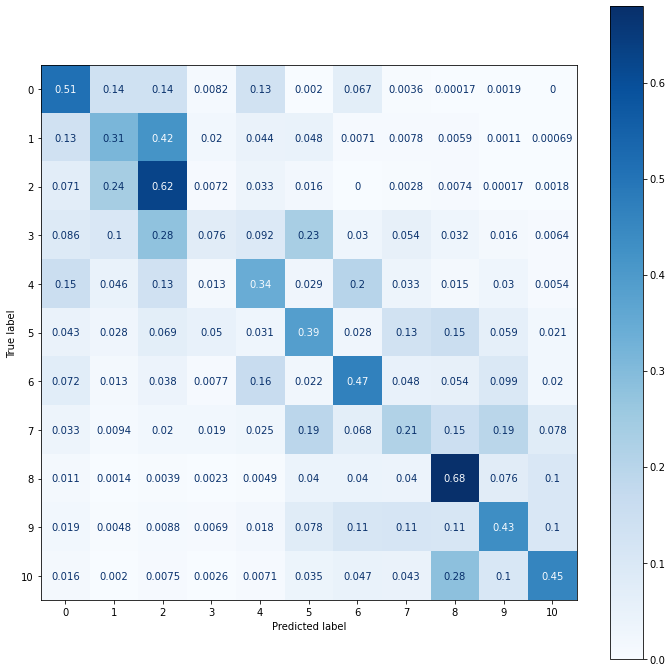

In [7]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

start = datetime.now()
print("학습 시작시간:", start)

lgbm = LGBMClassifier(objective='multiclass',
                      n_estimators=400, learning_rate=0.01,
                     random_state=42)
lgbm.fit(X_train, y_train)
end = datetime.now()
print("학습 종료시간:", end)
print("학습 러닝타임:", end-start)
print()

y_train_pred = lgbm.predict(X_train)
y_val_pred = lgbm.predict(X_val)
labels = [a for a in range(0,11)]
train_acc = accuracy_score(y_train, y_train_pred)
acc, pre, rec, f1 = get_eval(y_val, y_val_pred, labels)

print(f"학습 데이터에 대한 정확도: {train_acc: .4f}")
print(f"테스트 데이터에 대한 정확도: {acc: .4f}")
scores_df = pd.DataFrame(data={'Precision':pre,
                               'Recall':rec,
                               'F1-score':f1}, index=labels)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(lgbm, X_val, y_val, normalize='true',
                     cmap=plt.cm.Blues, ax=ax)
plt.show()

In [8]:
scores_df

,Precision,Recall,F1-score
0,0.444638,0.511882,0.475896
1,0.350276,0.313408,0.330818
2,0.359850,0.623857,0.456426
3,0.357623,0.075900,0.125224
4,0.386258,0.343411,0.363576
5,0.356640,0.387286,0.371332
6,0.440599,0.465004,0.452472
7,0.307832,0.213054,0.251820
8,0.458818,0.679414,0.547739
9,0.427104,0.434408,0.430725


# Random Forest로 선정!

학습 시작시간:  2020-10-30 14:55:55.876806
학습 종료시간:  2020-10-30 15:01:42.267189
학습 러닝타임:  0:05:46.390383

학습 데이터에 대한 정확도:  0.8589
테스트 데이터에 대한 정확도:  0.6047


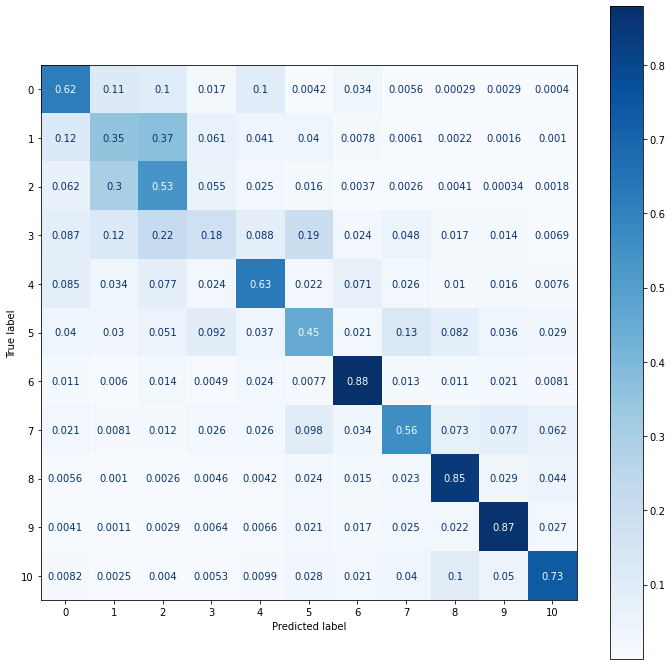

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
#import shap
from datetime import datetime

start = datetime.now()
print("학습 시작시간: ", start)
rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10)
rf_clf.fit(X_train, y_train)
end = datetime.now()
print("학습 종료시간: ", end)
print("학습 러닝타임: ", end-start)
print()
#explainer = shap.TreeExplainer(rf_clf)
#shap_values = explainer.shap_values(X_train)

y_train_pred = rf_clf.predict(X_train)
y_val_pred = rf_clf.predict(X_val)
labels = [a for a in range(0,11)]
train_acc = accuracy_score(y_train, y_train_pred)

acc, pre, rec, f1 = get_eval(y_val, y_val_pred, labels)

print(f"학습 데이터에 대한 정확도: {train_acc: .4f}")
print(f"테스트 데이터에 대한 정확도: {acc: .4f}")
scores_df = pd.DataFrame(data={'Precision':pre,
                               'Recall':rec,
                               'F1-score':f1}, index=labels)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf_clf, X_val, y_val, normalize='true',
                     cmap=plt.cm.Blues, ax=ax)
plt.show()

In [11]:
scores_df

,Precision,Recall,F1-score
0,0.582194,0.617133,0.599155
1,0.361456,0.350560,0.355925
2,0.384368,0.533250,0.446731
3,0.383804,0.184729,0.249412
4,0.633051,0.623913,0.628449
5,0.497872,0.450397,0.472946
6,0.779868,0.878537,0.826267
7,0.640044,0.562547,0.598798
8,0.723200,0.847430,0.780402
9,0.777566,0.867210,0.819945


- 60%이상으로 잘 맞추는 클래스들 
    * 0번, 4번(60%대), 6번, 8번, 9번, 10번(7-80%)
- 60%미만으로 잘 못맞추는 클래스들
    * 1번(35%) : 1번인데 ``2번으로 잘못 예측하는 경우(37%)``
    * 2번(53%) : 2번인데 ``1번으로 잘못 예측하는 경우(30%)``
        - 1번과 2번 사이에서 모델이 많이 헷갈려하는 듯 하다.
    * **3번(18&)** : 3번인데 ``1번(12%), 2번(22%), 5번(19%)로 잘못 예측``
        - 3번은 여러 클래스로 오분류하는 것으로 보아 3번 클래스로 분류될 데이터들의 패턴이 명확히 보이지 않는 듯 하다
    * 5번(45%) : 5번인데 ``7번으로 잘못 예측하는 경우(13%)``
    * 7번(57%) : 7번인데 ``5번으로 잘못 예측하는 경우(9%)``<br><br>
- 결국 **재원일수 기간이 적은 범위의 클래스(0,1,2,3)에서 오분류가 많이 발생**..

In [11]:
# Class값들의 각 재원일수 기간
class_lst = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100','More than 100 Days']
class_dict = {}
for i, class_ in enumerate(class_lst):
    class_dict[i] = class_

In [12]:
class_dict

{0: '0-10',
 1: '11-20',
 2: '21-30',
 3: '31-40',
 4: '41-50',
 5: '51-60',
 6: '61-70',
 7: '71-80',
 8: '81-90',
 9: '91-100',
 10: 'More than 100 Days'}

## Feature Selection

### PCA

In [ ]:
# PCA 시도 => Kernel dead..
'''
from sklearn.decomposition import PCA
pca = PCA(n_components=7)

pca_X_train = pca.fit_transform(X_train)
'''

### Permutation Importance

In [7]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime

start = datetime.now()
print("학습 시작: ", start)
rf_clf = RandomForestClassifier(n_estimators=100,
                               criterion='entropy',
                               min_samples_split=10)

trained_model = rf_clf.fit(X_train, y_train)
end1 = datetime.now()
print("학습 종료: ", end1)
print("학습 러닝타임: ", end1-start)
result = permutation_importance(trained_model, X_train, y_train,
                               n_repeats=5, random_state=12)
end2 = datetime.now()
print("Feature selection 종료: ", end2)
print("Feature selection 걸린 시간: ", end2-end1)

학습 시작:  2020-10-14 14:45:23.308286
학습 종료:  2020-10-14 14:48:20.534805
학습 러닝타임:  0:02:57.226519
Feature selection 종료:  2020-10-14 15:20:59.689238
Feature selection 걸린 시간:  0:32:39.154433


In [45]:
# permutation Importance로 뽑은 Feature Importance(5번 반복한 후 평균값))
permut_importance = pd.DataFrame(data={'Feature_중요도':result.importances_mean,
                                      '중요도_표준편차':result.importances_std}, index=X_train.columns)
permut_importance = permut_importance.reset_index()

### Feature Importance of Random Forest

In [46]:
rf_ftr_importance = pd.DataFrame(data=rf_clf.feature_importances_, index=X_train.columns,
                                 columns=['Feature_중요도_RF'])
rf_ftr_importance = rf_ftr_importance.reset_index()

### Compare feature Importance(Permutation VS RF)

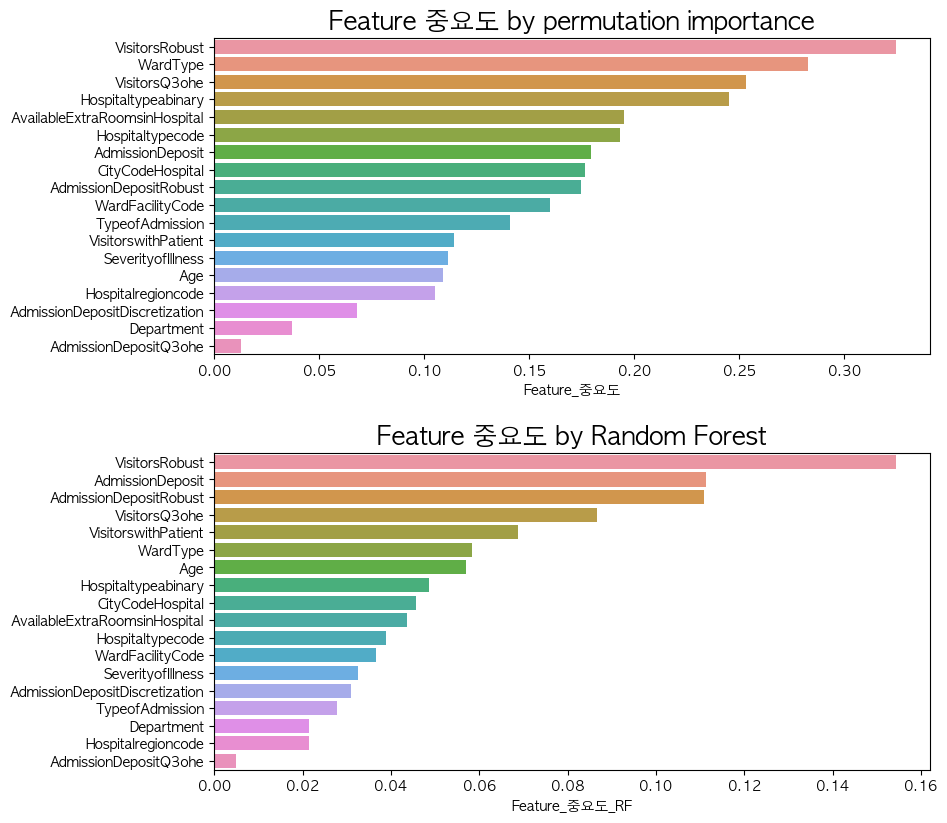

In [39]:
# Seaborn 그래프로 두 Featur Selection 방법으로 추출된 중요도 비교
fig, axes = plt.subplots(figsize=(9,9), ncols=1, nrows=2, dpi=100)
plt.tight_layout(pad=5)

sns.barplot(data=permut_importance, x='Feature_중요도', y=permut_importance.index, ax=axes[0])
sns.barplot(data=rf_ftr_importance, x='Feature_중요도_RF', y=rf_ftr_importance.index, ax=axes[1])

axes[0].set_title("Feature 중요도 by permutation importance", fontsize=18)
axes[1].set_title("Feature 중요도 by Random Forest", fontsize=18)
plt.show()

In [59]:
importance_merge = pd.merge(permut_importance, rf_ftr_importance, on='index')
importance_merge = importance_merge.set_index('index')
importance_merge.index = importance_merge.index.rename('Feature')

cols = ['Feature_중요도','Feature_중요도_RF','중요도_표준편차']
importance_merge = importance_merge[cols]
# Permutation Importance 기준으로 내림차순 정렬후 Random Forest와 비교
importance_merge = importance_merge.sort_values(by='Feature_중요도', ascending=False)
importance_merge

,Feature_중요도,Feature_중요도_RF,중요도_표준편차
Feature,,,
VisitorsRobust,0.324555,0.154346,0.000452
WardType,0.282710,0.058418,0.000333
VisitorsQ3ohe,0.253066,0.086558,0.000465
Hospitaltypeabinary,0.245098,0.048626,0.000536
AvailableExtraRoomsinHospital,0.195193,0.043722,0.000294
Hospitaltypecode,0.193293,0.038834,0.000219
AdmissionDeposit,0.179334,0.111397,0.000157
CityCodeHospital,0.176348,0.045614,0.000138
AdmissionDepositRobust,0.174425,0.110889,0.000242


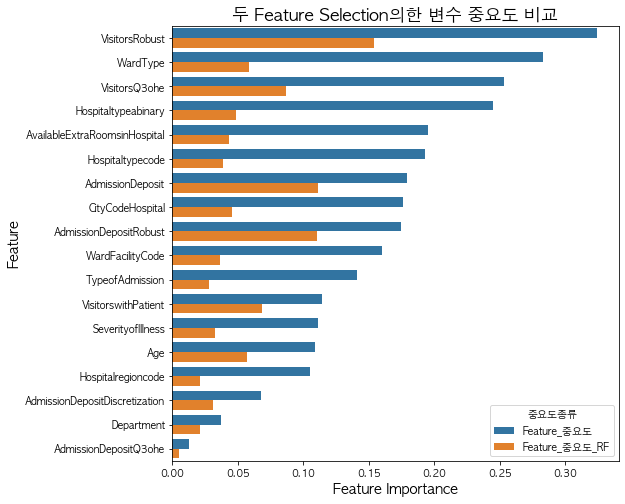

In [74]:
importance_stack = pd.DataFrame(importance_merge[['Feature_중요도','Feature_중요도_RF']].stack())
importance_stack = importance_stack.rename(columns={0:'중요도값'})
importance_stack = importance_stack.reset_index()
importance_stack = importance_stack.rename(columns={'level_1':'중요도종류'})

plt.figure(figsize=(8,8))
sns.barplot(data=importance_stack, x='중요도값', y='Feature', hue='중요도종류')
plt.title("두 Feature Selection의한 변수 중요도 비교", fontsize=17)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.show()

### 변수 Selection / Drop
#### 1번째 

- 공통 제거해야할 변수
    * AdmissionDepositQ3ohe
    * Department
    * AdmissionDepositDiscretization

In [10]:
com_cols = ['AdmissionDepositQ3ohe','Department','AdmissionDepositDiscretization']
remove_common_df = label_smote_df.drop(com_cols, axis=1)
remove_common_df.columns

Index(['Hospitaltypecode', 'CityCodeHospital', 'Hospitalregioncode',
       'WardType', 'WardFacilityCode', 'TypeofAdmission', 'SeverityofIllness',
       'Age', 'Hospitaltypeabinary', 'AvailableExtraRoomsinHospital',
       'VisitorswithPatient', 'AdmissionDeposit', 'VisitorsRobust',
       'VisitorsQ3ohe', 'AdmissionDepositRobust', 'YStay'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split

feature = remove_common_df.iloc[:,:-1]
target = remove_common_df.iloc[:, -1]

X_train, X_val_test, y_train, y_val_test = train_test_split(feature, target, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=43)

print(f"Train 데이터 개수/비율:{X_train.shape[0]},{int((X_train.shape[0]/feature.shape[0])*100)}%")
print(f"Validation 데이터 개수/비율:{X_val.shape[0]},{int((X_val.shape[0]/feature.shape[0])*100)}%")
print(f"Test 데이터 개수/비율:{X_test.shape[0]},{int((X_test.shape[0]/feature.shape[0])*100)}%")

Train 데이터 개수/비율:577440,59%
Validation 데이터 개수/비율:192480,19%
Test 데이터 개수/비율:192481,20%


학습 시작시간:  2020-10-30 15:20:15.777683
학습 종료시간:  2020-10-30 15:25:31.926538
학습 러닝타임:  0:05:16.148855

학습 데이터에 대한 정확도:  0.8415
테스트 데이터에 대한 정확도:  0.5879


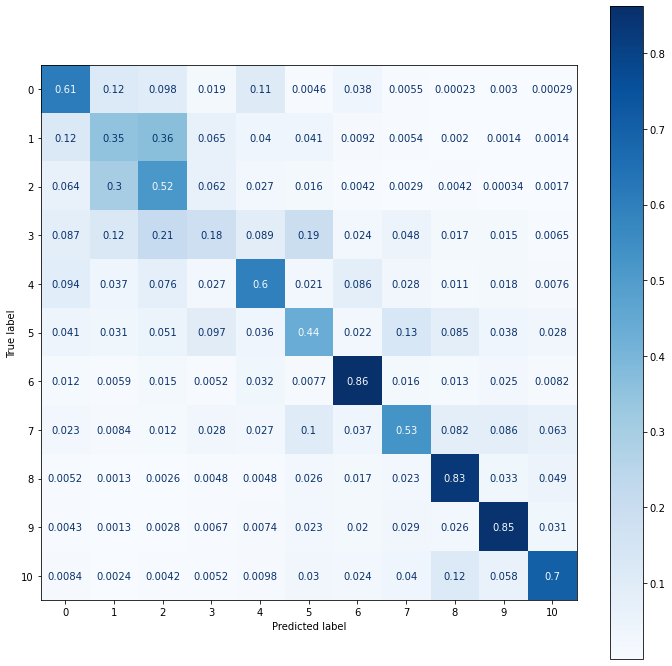

In [13]:
# 공통 제거할 변수 제거하고 Random Forest 재모델링
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

start = datetime.now()
print("학습 시작시간: ", start)
rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10)
rf_clf.fit(X_train, y_train)
end = datetime.now()
print("학습 종료시간: ", end)
print("학습 러닝타임: ", end-start)
print()
y_train_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_val)
labels = [a for a in range(0,11)]

train_acc = accuracy_score(y_train, y_train_pred)
acc, pre, rec, f1 = get_eval(y_val, y_pred, labels)

print(f"학습 데이터에 대한 정확도: {train_acc: .4f}")
print(f"테스트 데이터에 대한 정확도: {acc: .4f}")
scores_df = pd.DataFrame(data={'Precision':pre,
                               'Recall':rec,
                               'F1-score':f1}, index=labels)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf_clf, X_val, y_val, normalize='true',
                     cmap=plt.cm.Blues, ax=ax)
plt.show()

#### 2번째

- 중요도 상위값의 변수들만 선정
- Permutation Importance
    * VisitorsRobust
    * WardType
    * VisitorsQ3ohe
    * Hospitaltypeabinary
- Feature Importance by RF
    * VisitorsRobust
    * AdmissionDeposit
    * AdmissionDepositRobust
<br><br>
- 하지만 데이터 분석 결과, 입원 보증금(AdmissionDeposit)은 재원일수(종속변수)와 관계가 없는 것으로 판단되어 입원 보증금을 상위 중요도로 결과를 낸 **RF의 Feature Importance기준을 사용하지 않기로 결정!**

In [9]:
from sklearn.model_selection import train_test_split

pi_df = label_smote_df[['VisitorsRobust', 'WardType','VisitorsQ3ohe','Hospitaltypeabinary','YStay']]

feature = pi_df.iloc[:,:-1]
target = pi_df.iloc[:, -1]

X_train, X_val_test, y_train, y_val_test = train_test_split(feature, target, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=43)

print(f"Train 데이터 개수/비율:{X_train.shape[0]},{int((X_train.shape[0]/feature.shape[0])*100)}%")
print(f"Validation 데이터 개수/비율:{X_val.shape[0]},{int((X_val.shape[0]/feature.shape[0])*100)}%")
print(f"Test 데이터 개수/비율:{X_test.shape[0]},{int((X_test.shape[0]/feature.shape[0])*100)}%")

Train 데이터 개수/비율:577440,59%
Validation 데이터 개수/비율:192480,19%
Test 데이터 개수/비율:192481,20%


학습 시작시간:  2020-10-19 16:23:09.672643
학습 종료시간:  2020-10-19 16:27:35.728335
학숩 러닝타임:  0:04:26.055692
테스트 데이터에 대한 정확도:  0.3135


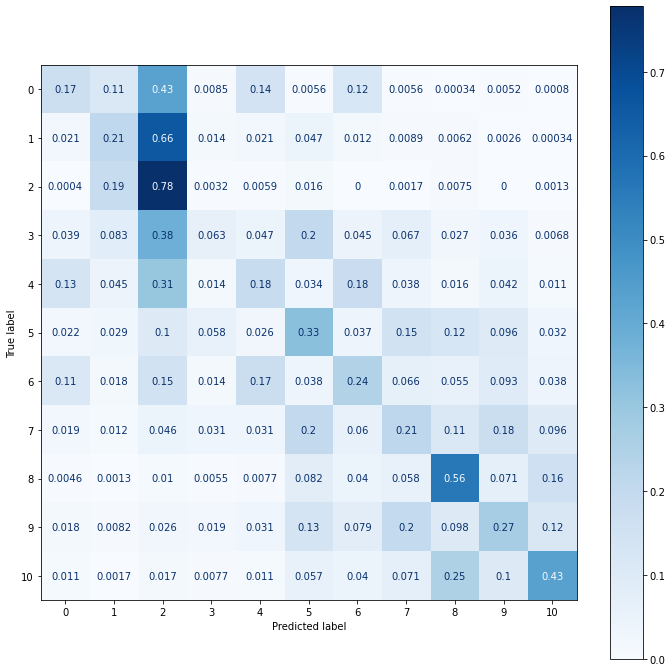

In [13]:
# Permutation Importance기준 상위 변수만을 갖고 Random Forest 재모델링
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

start = datetime.now()
print("학습 시작시간: ", start)
rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10)
rf_clf.fit(X_train, y_train)
end = datetime.now()
print("학습 종료시간: ", end)
print("학숩 러닝타임: ", end-start)

y_pred = rf_clf.predict(X_val)
labels = [a for a in range(0,11)]

acc, pre, rec, f1 = get_eval(y_val, y_pred, labels)
print(f"테스트 데이터에 대한 정확도: {acc: .4f}")
scores_df = pd.DataFrame(data={'Precision':pre,
                               'Recall':rec,
                               'F1-score':f1}, index=labels)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf_clf, X_val, y_val, normalize='true',
                     cmap=plt.cm.Blues, ax=ax)
plt.show()

- 상위 변수로 모델링 했더니 정확도가 오히려 더 낮아짐

# 종속 변수 클래스 축소

- 하지만 도메인 지식 조사(병원 의무기록사로 일하는 지인을 통해 도메인 지식 요청) 결과, ``모델이 가장 헷갈려하는 클래스 0(0-10)/1(11-20)/2(21-30)을 20일 기준으로 나누려고 했지만 도메인 지식 관점 하에 위험성이 수반.``
- 또한 자료 조사 결과, <a href='https://khanews.com/news/articleView.html?idxno=665'>단기 입원일은 14일 이내</a>로 판단되며 클래스를 ``0(0-10) / 1(11-20) / 2(21-30)`` 에서 ``0(0-10) / 1(11-20 & 21-30)`` 으로 클래스를 병합!

In [17]:
# 클래스 범위 축소, 병합
class_map = {0:0, 1:1, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9, 11:19}
label_smote_df['YStay'] = label_smote_df['YStay'].map(class_map)

In [19]:
label_smote_df['YStay'].unique()

array([0, 3, 2, 1, 4, 6, 9, 7, 5, 8])

In [21]:
# 클래스 범위 축소후 Random Forest 재모델링
from sklearn.model_selection import train_test_split

feature = label_smote_df.iloc[:,:-1]
target = label_smote_df.iloc[:, -1]

X_train, X_val_test, y_train, y_val_test = train_test_split(feature, target, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=43)

print(f"Train 데이터 개수/비율:{X_train.shape[0]},{int((X_train.shape[0]/feature.shape[0])*100)}%")
print(f"Validation 데이터 개수/비율:{X_val.shape[0]},{int((X_val.shape[0]/feature.shape[0])*100)}%")
print(f"Test 데이터 개수/비율:{X_test.shape[0]},{int((X_test.shape[0]/feature.shape[0])*100)}%")

Train 데이터 개수/비율:577440,59%
Validation 데이터 개수/비율:192480,19%
Test 데이터 개수/비율:192481,20%


## 학습 시작시간:  2020-10-19 18:20:24.659962
## 학습 종료시간:  2020-10-19 18:26:38.913049
## 학습 러닝타임:  0:06:14.253087


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', l

## 학습 데이터에 대한 정확도:  0.8578
## 테스트 데이터에 대한 정확도:  0.6709


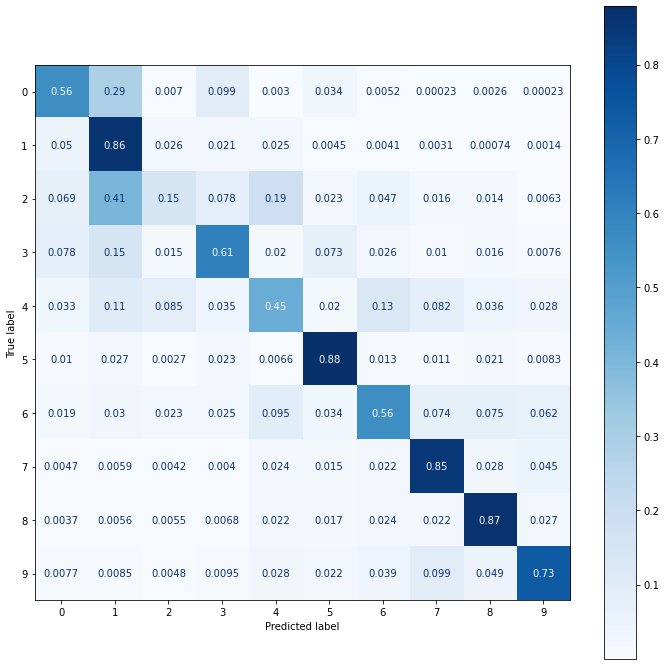

In [23]:
# 클래스 범위 축소, 병합 후 재모델링
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

start = datetime.now()
print("## 학습 시작시간: ", start)
rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10)
rf_clf.fit(X_train, y_train)
end = datetime.now()
print("## 학습 종료시간: ", end)
print("## 학습 러닝타임: ", end-start)

y_train_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_val)
labels = [a for a in range(0,11)]

train_acc = accuracy_score(y_train, y_train_pred)
acc, pre, rec, f1 = get_eval(y_val, y_pred, labels)
print(f"## 학습 데이터에 대한 정확도: {train_acc: .4f}")
print(f"## 테스트 데이터에 대한 정확도: {acc: .4f}")
scores_df = pd.DataFrame(data={'Precision':pre,
                               'Recall':rec,
                               'F1-score':f1}, index=labels)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf_clf, X_val, y_val, normalize='true',
                     cmap=plt.cm.Blues, ax=ax)
plt.show()

In [24]:
# Precision, Recall , F1-score
scores_df

,Precision,Recall,F1-score
0,0.631650,0.560900,0.594177
1,0.626856,0.864429,0.726719
2,0.431379,0.150317,0.222946
3,0.654252,0.605956,0.629178
4,0.503708,0.445051,0.472566
5,0.781903,0.878252,0.827282
6,0.642137,0.562031,0.599419
7,0.726216,0.847487,0.782179
8,0.779509,0.867095,0.820973
9,0.797013,0.732726,0.763519


- 학습 데이터에는 85%로 어느정도 높은 성능을 보였지만 검증(테스트용) 데이터에는 67%로 심각한 과대적합 문제가 발생
- 그래서 모델을 덜 복잡하게 만들기 위해 Permutation Importance 기반 상위 Feature를 가지고 과대적합 문제 해결해보기

## Overfitting 해결 위해 Feature 개수 축소 후 모델링

In [25]:
from sklearn.model_selection import train_test_split

pi_df = label_smote_df[['VisitorsRobust', 'WardType','VisitorsQ3ohe','Hospitaltypeabinary','YStay']]

feature = pi_df.iloc[:,:-1]
target = pi_df.iloc[:, -1]

X_train, X_val_test, y_train, y_val_test = train_test_split(feature, target, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=43)

print(f"Train 데이터 개수/비율:{X_train.shape[0]},{int((X_train.shape[0]/feature.shape[0])*100)}%")
print(f"Validation 데이터 개수/비율:{X_val.shape[0]},{int((X_val.shape[0]/feature.shape[0])*100)}%")
print(f"Test 데이터 개수/비율:{X_test.shape[0]},{int((X_test.shape[0]/feature.shape[0])*100)}%")

Train 데이터 개수/비율:577440,59%
Validation 데이터 개수/비율:192480,19%
Test 데이터 개수/비율:192481,20%


## 학습 시작시간:  2020-10-19 18:34:27.945355
## 학습 종료시간:  2020-10-19 18:38:59.409697
## 학습 러닝타임:  0:04:31.464342


/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', l

## 학습 데이터에 대한 정확도:  0.5390
## 테스트 데이터에 대한 정확도:  0.3905


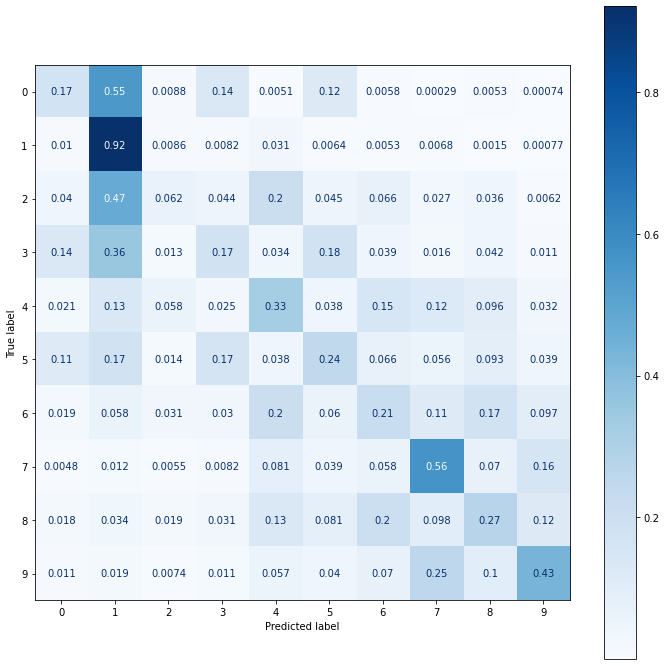

In [26]:
# 클래스 축소한 후 Permutation Importance기준 상위 변수만을 갖고 Random Forest 재모델링
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

start = datetime.now()
print("## 학습 시작시간: ", start)
rf_clf = RandomForestClassifier(n_estimators=200,
                               criterion='entropy',
                               min_samples_split=10)
rf_clf.fit(X_train, y_train)
end = datetime.now()
print("## 학습 종료시간: ", end)
print("## 학습 러닝타임: ", end-start)

y_train_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_val)
labels = [a for a in range(0,11)]

train_acc = accuracy_score(y_train, y_train_pred)
acc, pre, rec, f1 = get_eval(y_val, y_pred, labels)
print(f"## 학습 데이터에 대한 정확도: {train_acc: .4f}")
print(f"## 테스트 데이터에 대한 정확도: {acc: .4f}")
scores_df = pd.DataFrame(data={'Precision':pre,
                               'Recall':rec,
                               'F1-score':f1}, index=labels)
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(rf_clf, X_val, y_val, normalize='true',
                     cmap=plt.cm.Blues, ax=ax)
plt.show()

- Feature개수를 줄임으로써 모델 복잡도를 단순화시켰지만 오히려 ``학습, 검증 데이터에 대한 정확도가 훨씬 낮아짐``

# 모델링 한계점

- 현재 모델링 성능으로 교차검증까지 하는 의미가 없음
- 따라서, 다음과 같은 조치를 취함
    * Feature selection : Feature를 줄여봤으나 오히려 성능이 저하됨
    * 클래스 범위 축소 : 범위를 축소함으로써 성능의 일부 개선이 실현됬지만, 여전히 서비스화시킬 정도의 성능은 안 됨
- 또한, 오버샘플링으로 인한 데이터 개수 증대와 Feature개수가 많아짐으로써 학습 컴퓨팅 시 기본 거의 6분이상이 걸림
- 원-핫 인코딩 데이터를 학습시켜보고 싶었지만 컴퓨팅 한계로 바로 Kernel이 죽어버림..
- 모델 사후 분석결과, 클래스 범위를 더 단순화시킴으로써 성능을 개선하고 싶었지만, 도메인 지식의 부족으로 함부로 줄일 수 없기에 한 번의 클래스 범위 축소 수행을 끝으로 더 이상 진행하지 않음
- 모델 사후 분석결과, 0,1,2,4,6번에 대해 모델이 매우 헷갈려함..